# SN10 classifier and integrated gradients attribution

In this notebook, we develop the SN10 classifier used in `Absolut!` and the integrated-gradients method of attribution. We might also check other attribution methods.

In [1]:
import os
from pathlib import Path
from typing import List

import pandas as pd
import numpy as np
import seaborn as sns
import joypy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from captum.attr import IntegratedGradients

import NegativeClassOptimization.config as config
import NegativeClassOptimization.preprocessing as preprocessing

/home/eugen/miniconda3/envs/ab-negative-training/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's load the data on which we are going to develop the binary classifier.

In [2]:
df = pd.read_csv(config.DATA_SLACK_1_GLOBAL, sep='\t')

ag_pos = "3VRL"
ag_neg = "1ADQ"
df = df.loc[df["Antigen"].isin([ag_pos, ag_neg])].copy()

df.head(2)

,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,1873658_06a,CARPENLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_1873658_06a,3VRL
1,7116990_04a,CARGLLLLLWYFDVW,True,LLLLLWYFDVW,-112.82,137442-BRDSLLUDLS,3VRL_7116990_04a,3VRL


First, handle duplicates.

In [3]:
def prepare_data(df: pd.DataFrame, pos_ag: str) -> pd.DataFrame:
    """Prepare data for SN10 training and evaluation. 
    Most importantly - appropriately removes duplicates. 

    Args:
        df (pd.DataFrame): typical dataframe used in the project
        pos_ag (str): the antigen assuming the positive dataset role

    Returns:
        pd.DataFrame: df with new columns suitable for modelling.
    """
    
    def infer_antigen_from_duplicate_list(antigens: List[str], pos_antigen: str):
        assert len(antigens) <= 2, ">2 antigens not supported yet."
        if len(antigens) == 1:
            return antigens[0]
        else:
            if pos_antigen in antigens:
                return pos_antigen
            else:
                return list(set(antigens) - set([pos_antigen]))[0]

    df = df.groupby("Slide").apply(
        lambda df_: infer_antigen_from_duplicate_list(df_["Antigen"].unique().tolist(), pos_antigen=ag_pos)
    )
    df = pd.DataFrame(data=df, columns=["Antigen"])
    df = df.reset_index()
    return df


df = prepare_data(df, ag_pos)

preprocessing.onehot_encode_df(df);

df["X"] = df["Slide_onehot"]
df["y"] = np.where(df["Antigen"] == ag_pos, 1, 0)

df.head(3)

,Slide,Antigen,Slide_onehot,X,y
0,AAELFWYFDVW,3VRL,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
1,AAFITTVGWYF,1ADQ,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
2,AAFYGRWYFDV,1ADQ,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [4]:
class PairwiseDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        return (
            torch.tensor(self.df.loc[idx, "X"]).reshape((1, -1)).type(torch.float),
            torch.tensor(self.df.loc[idx, "y"]).reshape((1)).type(torch.float),
        )


batch_size = 64
train_frac = 0.8
df = df.sample(frac=1).reset_index(drop=True)  # shuffle

split_idx = int(df.shape[0] * train_frac)
df_train = df.loc[:split_idx].copy().reset_index(drop=True)
df_test = df.loc[split_idx:].copy().reset_index(drop=True)

train_data = PairwiseDataset(df_train)
test_data = PairwiseDataset(df_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Define the model.

In [5]:
class SN10(nn.Module):
    def __init__(self):
        super(SN10, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(11*20, 10),
            nn.ReLU(),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = SN10().to(device)
print(model)

Using cpu device
SN10(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=220, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=1, bias=True)
    (3): Sigmoid()
  )
)


Setup the optimization loop.

In [6]:
learning_rate = 0.01
epochs = 5

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.BCELoss()

In [7]:
def train_loop(loader, model, loss_fn, optimizer):
    size = len(loader.dataset)
    for batch, (X, y) in enumerate(loader):
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(loader, model, loss_fn):
    size = len(loader.dataset)
    num_batches = len(loader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in loader:
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()
            correct += (torch.round(y_pred) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.690720  [    0/66571]
loss: 0.681421  [ 6400/66571]
loss: 0.683116  [12800/66571]
loss: 0.675709  [19200/66571]
loss: 0.655223  [25600/66571]
loss: 0.629626  [32000/66571]
loss: 0.631616  [38400/66571]
loss: 0.581512  [44800/66571]
loss: 0.550792  [51200/66571]
loss: 0.545783  [57600/66571]
loss: 0.504910  [64000/66571]
Test Error: 
 Accuracy: 81.0%, Avg loss: 0.490365 

Epoch 2
-------------------------------
loss: 0.504404  [    0/66571]
loss: 0.544960  [ 6400/66571]
loss: 0.455386  [12800/66571]
loss: 0.479714  [19200/66571]
loss: 0.498458  [25600/66571]
loss: 0.420258  [32000/66571]
loss: 0.449873  [38400/66571]
loss: 0.393275  [44800/66571]
loss: 0.378630  [51200/66571]
loss: 0.374265  [57600/66571]
loss: 0.413522  [64000/66571]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.366147 

Epoch 3
-------------------------------
loss: 0.362378  [    0/66571]
loss: 0.441171  [ 6400/66571]
loss: 0.324821  [12800/66571]
loss: 0.376116  [19200/665

Having trained a model, we explore integrated gradients as an attribution method. As baseline, we use the zero one-hot tensor. 

Computing integrated gradients for feature $i$:

$$\text{IntegratedGrads}_i^{approx}(x) = (x_i-x_i') \cdot \frac{1}{m} \cdot \sum_{k=1}^{m}\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}$$

Essential for the implementation is computing:

$$\frac{\partial F(x'+\frac{k}{m}\cdot (x-x'))}{\partial x_i}, \text{ where }F(x)\text{ is the SN10}$$

One issue concerns the baseline. I'm not sure a zero-valued one-hot vector is the relevant baseline. I should maybe try different baselines (such as different aminoacids, or some specific sequence). Also, Euclidian interpolation might not be relevant as well.

In any case, [Captum](https://captum.ai/) provides implementations for many interpretability methods. It looks like it also has interpretability methods for NLP models. It also has [a useful section](https://captum.ai/docs/algorithms_comparison_matrix) that compares algorithms.

For first, let's go with integrated gradients and compute for all the test set. It would also be useful to add visualisation like [Captum Insights](https://captum.ai/tutorials/CIFAR_TorchVision_Captum_Insights).

In [9]:
ig = IntegratedGradients(model)

inputs = tuple(map(
    lambda pair: pair[0].reshape((-1, 11*20)),
    DataLoader(test_data, batch_size=1)
))

records = []
for input in inputs:
    attributions, approximation_error = ig.attribute(
        inputs=input,
        baselines=0,
        n_steps=100,
        method="gausslegendre",
        return_convergence_delta=True,
    )
    records.append((attributions, approximation_error))

abs_sums = []
for record in records:
    abs_sum = record[0].reshape((11, 20)).abs().sum(axis=1).numpy()
    abs_sums.append(abs_sum)

df_attr = pd.DataFrame(data=np.stack(abs_sums), columns=range(1, 12))

(<Figure size 432x288 with 12 Axes>,
 [<AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>,
  <AxesSubplot:>])

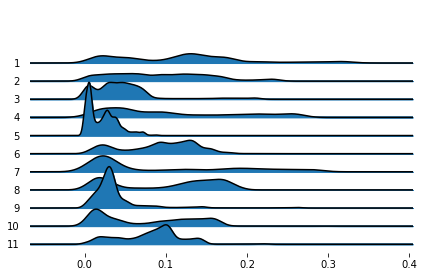

In [10]:
joypy.joyplot(df_attr)